In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from importlib import reload
import emcee
import numpy as np
import matplotlib.pyplot as plt
from spectra import Spectrum

In [36]:
from numpy import exp, sqrt, pi
def delta_l_from_delta_v(delta_velocity, lambda_rest):
    return delta_velocity*lambda_rest/299792.458 #d_v is in km/s not in m/s

def lnL(theta, x, y, yerr, lambda_rest, c):
    amp,sigma,delta_velocity, c = theta
    delta_lambda = delta_l_from_delta_v(delta_velocity,lambda_rest)
    model = c - (amp / (sqrt(2*pi) * sigma)) * exp(-(x+delta_lambda-lambda_rest)**2 / (2*sigma**2))
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2))

def lnprior(theta):
    amp,sigma,delta_velocity,c = theta
    if 0 < sigma < 10 and -100 < delta_velocity < 100:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr, lambda_rest, c):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnL(theta, x, y, yerr, lambda_rest, c)

In [37]:
# problem3
from __future__ import print_function

import numpy as np
import emcee
import sys
import matplotlib.pyplot as plt
import corner


def run_emcee(x, y_obs, sigma, lambda_rest, c, ml_result): #ml_result is the result object from lmfit

    # Set up the properties of the problem.
    ndim, nwalkers = 4, 200

    # Setup a bunch of starting positions.
    pos = [ml_result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
        
    # Create the sampler.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_obs, sigma, lambda_rest, c))

    sampler.run_mcmc(pos, 500)

    samples = sampler.chain[:, 300:, :].reshape((-1, 4))

    return sampler, samples



def show_walkers(chain, labels, savefile=None):

    nwalkers, nreps, ndim = chain.shape

    xval = np.arange(0, nreps)

    fig, ax = plt.subplots(ncols=1, nrows=ndim, figsize=(14, 4))
    for i_dim in range(ndim):
        ax[i_dim].set_ylabel(labels[i_dim])
        
        for i in range(100):
            ax[i_dim].plot(xval, chain[i, :, i_dim], color='black', alpha=0.5)

    if savefile is not None:
        plt.savefig(savefile)

    return fig, ax


def show_corner_plot(samples,labels,truths, savefile=None):

    fig = corner.corner(samples, labels=labels, truths=truths, quantiles=[0.16,0.5,0.84])

    
    if savefile is not None:
        plt.savefig(savefile)

    return fig

In [43]:
spec = Spectrum('src/data-spectrum/new/idid000007077jd2458163p6789f000.fits')
#lambda_rest = 4861.297
#spec.plot('-r',4340,4780)
lambda_rest = 6562.85175
#spec.gfitting([lT],False)
#spec.plot('-r',4840,4880)


In [60]:
data = spec.fit_unique(lambda_rest,6550,6580)
#spec.gfitting([lambda_rest],True)
amp = data['result'].params['amp'].value
sigma = data['result'].params['sigma'].value
lambdaObs = data['result'].params['lambda0'].value
delta_velocity = 299792.458*(lambdaObs-lambda_rest)/lambda_rest
y0 = data['y'][0]

In [64]:
# See ml_illustration for the run_ml() function that calculates these numbers.
p_initial = [amp,sigma,delta_velocity, y0]#values from result object
print(p_initial)
sampler_gaussian, samples_gaussian = run_emcee(data['x'], data['y'], data['sigma'], lambda_rest, y0, p_initial)

[-2503.290762904678, 4.207051004934521, 42.01599757833922, 592.79254]


### Show the chains

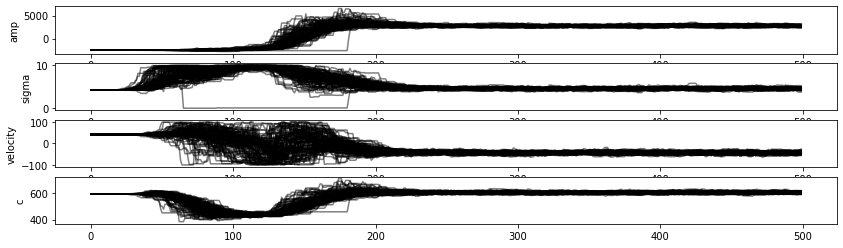

In [62]:
fig, axes = show_walkers(sampler_gaussian.chain, ['amp', 'sigma', 'velocity', 'c'])


### Show a corner plot

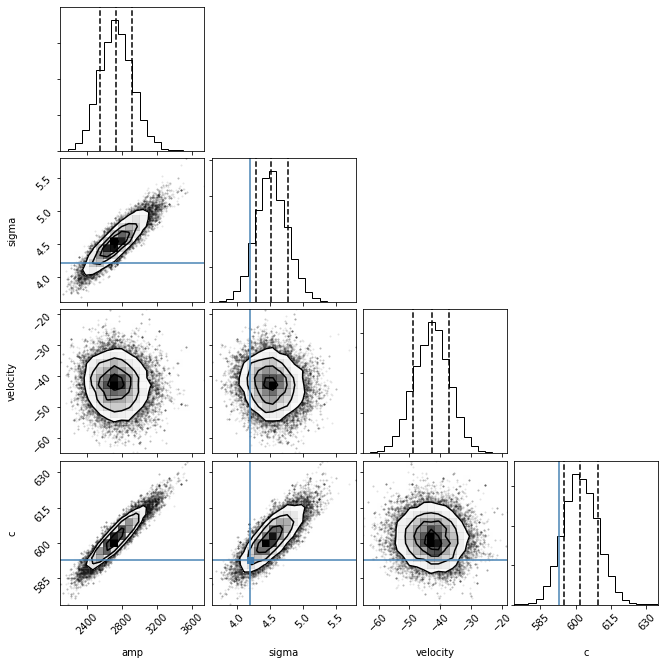

In [63]:
fig = show_corner_plot(samples_gaussian, ['amp','sigma','velocity','c'], p_initial)